# 0.0 Imports

In [1]:
#!pip install sklearn
#!pip install scikit-plot
#!pip install imblearn
#!pip install ydata-profiling
#!pip install ipywidgets
#!pip install xgboost

In [2]:
import random

import pandas                                     as pd
import numpy                                      as np
import seaborn                                    as sns
import ipywidgets                                 as widgets

from xgboost               import XGBClassifier
from matplotlib            import pyplot          as plt
from sklearn               import model_selection as ms
from sklearn               import preprocessing   as pp
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn               import metrics         as m

from scikitplot            import metrics         as mt
from scipy                 import stats           as ss


from keras                 import models          as ml
from keras                 import layers          as l

from imblearn              import under_sampling  as us
from imblearn              import over_sampling   as oversample
from imblearn              import combine         as c

from ydata_profiling       import ProfileReport

from category_encoders     import TargetEncoder

from boruta                import BorutaPy
from sklearn.ensemble      import RandomForestRegressor

from sklearn.neighbors     import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV


## 0.1 - Helper Functions

In [3]:
def cramer_v( x, y ):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( ( chi2corr/n ) / ( min( kcorr - 1, rcorr - 1 ) ) )


def prepare_data(df):
    
    #==============Remove Nan================
    
    #date_first_booking

    date_first_booking_max = pd.to_datetime(df['date_first_booking'], format = '%Y-%m-%d').max()
    df['date_first_booking'] = df['date_first_booking'].fillna(date_first_booking_max)

    #age

    df = df[(df['age'] > 15) & (df['age'] < 120)]
    avg_age = df['age'].mean().astype(int)
    df['age'] = df['age'].fillna(avg_age)

    #first_affiliate_tracked

    df = df[~ df['first_affiliate_tracked'].isna()]
    
    #================Change Types=========================
    
    
    #date_account_created

    df['date_account_created'] = pd.to_datetime(df['date_account_created'])

    #timestamp_first_active

    df['timestamp_first_active'] = pd.to_datetime(df['timestamp_first_active'], format = '%Y%m%d%H%M%S')

    #date_first_booking

    df['date_first_booking'] = pd.to_datetime(df['date_first_booking'])

    #age

    df['age'] = df['age'].astype(np.int64)
    
    df2 = df.copy()
    
    #=========================New Features=========================
    
    #days from first active up to first booking

    df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
    df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

    #days from first active up to account created

    df2['days_from_account_created_until_active'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

    #days from account created to first booking

    df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

    #days from first active until account created

    df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

    #Year of first active

    df2['year_first_active'] = df2['first_active'].dt.year

    #Month of first active

    df2['month_first_active'] = df2['first_active'].dt.month

    #Day of first active

    df2['day_first_active'] = df2['first_active'].dt.day

    #Day of week of first active

    df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

    #Week of year first active

    df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

    #Year of first booking

    df2['year_first_booking'] = df2['date_first_booking'].dt.year

    #Month of first booking

    df2['month_first_booking'] = df2['date_first_booking'].dt.month


    #Day of first booking

    df2['day_first_booking'] = df2['date_first_booking'].dt.day


    #Day of week of first booking

    df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

    #Week of year first booking

    df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

    #Year of account created

    df2['year_account_created'] = df2['date_account_created'].dt.year

    #Month of account created

    df2['month_account_created'] = df2['date_account_created'].dt.month


    #Day of account created

    df2['day_account_created'] = df2['date_account_created'].dt.day


    #Day of week of account created

    df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

    #Week of year account created

    df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear
    
    df3 = df2.copy()
    
    #===================Filtering Rows and Columns=====================================
    
    df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]
    
    cols = ['date_account_created','timestamp_first_active','date_first_booking','first_active'] #original datetime
    
    #======================Encoders===================================
    
    df4 = df3.drop(cols, axis = 1)
    
    # columns numerical

    col_num = df4.select_dtypes(include = ['int64','float64']).columns.tolist()

    # columns categorical

    col_cat = df4.select_dtypes(exclude = ['int64','float64','datetime64[ns]']).drop(['id'], axis = 1).columns.tolist()

    # Encoder

    ohe = pp.OneHotEncoder()

    df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index = df4.index)

    #Join

    df42 = pd.concat([df4[col_num], df4_dummy], axis = 1)

    df42.columns = df42.columns.astype(str)
    
    df45 = pd.DataFrame(ohe.inverse_transform(df4_dummy), columns = col_cat, index = df4_dummy.index)
    
    df46 = pd.concat([df4[col_num], df45], axis = 1)
    
    
    cols_drop = ['days_from_first_active_until_booking','year_first_active','month_first_active','day_first_active',
       'day_of_week_first_active','week_of_year_first_active','month_first_booking','month_account_created',
       'year_first_booking','week_of_year_first_booking','affiliate_provider','first_browser',
       'first_device_type','language','days_from_account_created_until_active'] # High correlation
    
    #======================Remove columns with High correlation and Transformations =============================
    
    df6 = df46.drop(cols_drop, axis = 1)
    
    ss = pp.StandardScaler()
    rs = pp.RobustScaler()
    mms = pp.MinMaxScaler()
    le = pp.LabelEncoder()
    
    #RESCALING
    
    # Age - Standartization

    df6['age'] = ss.fit_transform(df6[['age']].values)

    #signup_flow - Robust Scaler

    df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

    #days_from_account_created_until_first_booking - Robust Scaler

    df6['days_from_account_created_until_first_booking'] = rs.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

    #days_from_first_active_until_account_created - Min Max Scaler

    df6['days_from_first_active_until_account_created'] = mms.fit_transform(df6[['days_from_first_active_until_account_created']].values)

    #year_account_created - Min Max Scaler

    df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)
    
    #ENCODER
    
    #gender - OHE

    df6 = pd.get_dummies(df6, prefix = ['gender'], columns = ['gender'])

    #signup_method - OHE

    df6 = pd.get_dummies(df6, prefix = ['signup_method'], columns = ['signup_method'])


    #signup_app - OHE

    df6 = pd.get_dummies(df6, prefix = ['signup_app'], columns = ['signup_app'])
    
    #affiliate_channel
    
    df6['affiliate_channel'] = le.fit_transform(df6['affiliate_channel'])
    
    #first_affiliate_tracked
    
    df6['first_affiliate_tracked'] = le.fit_transform(df6['first_affiliate_tracked'])
    
    #TRANSFORMATION
    
    #day_first_booking

    df6['day_first_booking_sin'] = df6['day_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/31)))
    df6['day_first_booking_cos'] = df6['day_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/31)))


    #day_of_week_first_booking

    df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #day_account_created

    df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/31)))
    df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/31)))

    #day_of_week_account_created

    df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
    df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

    #week_of_year_account_created

    df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
    df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))
    
    
    cols_boruta = ['age', 'signup_flow', 'days_from_account_created_until_first_booking',
       'day_first_booking', 'day_of_week_first_booking',
       'year_account_created', 'day_account_created',
       'day_of_week_account_created', 'week_of_year_account_created',
       'affiliate_channel', 'first_affiliate_tracked', 'signup_app_Web',
       'day_first_booking_sin', 'day_first_booking_cos',
       'day_of_week_first_booking_sin', 'day_of_week_first_booking_cos',
       'day_account_created_sin', 'day_account_created_cos',
       'day_of_week_account_created_cos', 'week_of_year_account_created_sin',
       'week_of_year_account_created_cos']
    
    #========================Feature Selection===================================
    
    df_test_prepared = df6[cols_boruta].copy()
    
    return df_test_prepared

## 0.2 - Loading data

In [4]:
df_raw = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001 - AirBNB/train_users.csv')
df_sessions_raw = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001 - AirBNB/sessions.csv') 
df_sessions_raw.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


# 1.0 Description Data

In [5]:
df1 = df_raw.copy()
df1_sessions = df_sessions_raw.copy()

## 1.1 Data Dimensions

In [6]:
print('df1 - Number of rows: {}'.format(df1.shape[0]))
print('df1 - Number of cols: {}'.format(df1.shape[1]))

df1 - Number of rows: 213451
df1 - Number of cols: 16


In [7]:
print('df sessions - Number of rows: {}'.format(df1_sessions.shape[0]))
print('df sessions - Number of cols: {}'.format(df1_sessions.shape[1]))

df sessions - Number of rows: 10567737
df sessions - Number of cols: 6


## 1.2 Data Type

In [8]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [9]:
df1_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 Check NA

In [10]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

In [11]:
aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts(normalize = True)

NDF      0.768428
US       0.156529
other    0.028617
FR       0.014888
IT       0.009081
GB       0.006251
ES       0.006171
CA       0.003989
DE       0.002387
NL       0.001818
AU       0.001171
PT       0.000671
Name: country_destination, dtype: float64

C:\Users\gabriel.ferreira\AppData\Local\Temp\ipykernel_2956\3840130964.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df1[df1['age'] < 65]['age'])


<AxesSubplot: xlabel='age', ylabel='Density'>

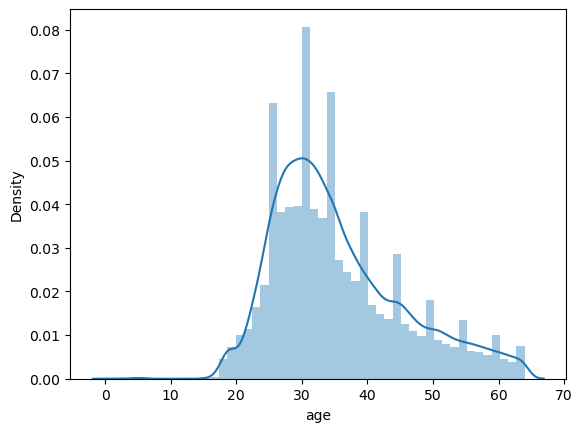

In [12]:
sns.distplot(df1[df1['age'] < 65]['age'])

In [13]:
#df1 = df1.dropna()
#df1.shape

#=============================================Users=============================================


#date_first_booking

date_first_booking_max = pd.to_datetime(df1['date_first_booking']).max().strftime('%Y-%m-%d')
df1['date_first_booking'] = df1['date_first_booking'].fillna(date_first_booking_max)

#age

df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = df1['age'].mean().astype(int)
df1['age'] = df1['age'].fillna(avg_age)

#first_affiliate_tracked

df1 = df1[~ df1['first_affiliate_tracked'].isna()]

#=============================================Sessions=============================================

df1_sessions = df1_sessions[~ df1_sessions['user_id'].isna()]

df1_sessions = df1_sessions[~ df1_sessions['action'].isna()]

df1_sessions = df1_sessions[~ df1_sessions['action_type'].isna()]

df1_sessions = df1_sessions[~ df1_sessions['action_detail'].isna()]

df1_sessions = df1_sessions[~ df1_sessions['device_type'].isna()]

df1_sessions = df1_sessions[~ df1_sessions['secs_elapsed'].isna()]


In [14]:
df1.isna().sum()

id                         0
date_account_created       0
timestamp_first_active     0
date_first_booking         0
gender                     0
age                        0
signup_method              0
signup_flow                0
language                   0
affiliate_channel          0
affiliate_provider         0
first_affiliate_tracked    0
signup_app                 0
first_device_type          0
first_browser              0
country_destination        0
dtype: int64

In [15]:
df1_sessions.isna().sum()

user_id          0
action           0
action_type      0
action_detail    0
device_type      0
secs_elapsed     0
dtype: int64

In [16]:
df1_sessions = df1_sessions.dropna()

## 1.4 Change Type

In [17]:
#date_account_created

df1['date_account_created'] = pd.to_datetime(df1['date_account_created'])

#timestamp_first_active

df1['timestamp_first_active'] = pd.to_datetime(df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')

#date_first_booking

df1['date_first_booking'] = pd.to_datetime(df1['date_first_booking'])

#age

df1['age'] = df1['age'].astype(np.int64)

df1.dtypes


id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 1.5 Check Balanced Data

In [18]:
df1['country_destination'].value_counts(normalize = True)

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.6 Descriptive Data

### 1.6.1 General

In [19]:
num_attributes = df1.select_dtypes(include = ['int64','float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])
time_attributes = df1.select_dtypes(include = ['datetime64[ns]'])

num_attributes_sessions = df1_sessions.select_dtypes(include = ['int64','float64'])
cat_attributes_sessions = df1_sessions.select_dtypes(exclude = ['int64','float64','datetime64[ns]'])
time_attributes_sessions = df1_sessions.select_dtypes(include = ['datetime64[ns]'])

### 1.6.2 Numerical Users

In [20]:
#Central Tendency - Mean, Median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion Tendency - Max, Min, Std, Range, Skew, Kurtosis

dt1 = pd.DataFrame(num_attributes.apply(max)).T
dt2 = pd.DataFrame(num_attributes.apply(min)).T
dt3 = pd.DataFrame(num_attributes.apply(np.std)).T
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

ct = pd.concat([dt1,dt2,dt4,ct1,ct2,dt3,dt5,dt6]).T.reset_index()
ct.columns = ['Attributes','Max','Min','Range','Mean','Median','Std','Skew','Kurtosis']
ct

,Attributes,Max,Min,Range,Mean,Median,Std,Skew,Kurtosis
0,age,115.0,16.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,25.0,0.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.6.3 Numerical Sessions

In [21]:
#Central Tendency - Mean, Median

ct1 = pd.DataFrame(num_attributes_sessions.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes_sessions.apply(np.median)).T


#Dispersion Tendency - Max, Min, Std, Range, Skew, Kurtosis

dt1 = pd.DataFrame(num_attributes_sessions.apply(max)).T
dt2 = pd.DataFrame(num_attributes_sessions.apply(min)).T
dt3 = pd.DataFrame(num_attributes_sessions.apply(np.std)).T
dt4 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes_sessions.apply(lambda x: x.kurtosis())).T

ct = pd.concat([dt1,dt2,dt4,ct1,ct2,dt3,dt5,dt6]).T.reset_index()
ct.columns = ['Attributes','Max','Min','Range','Mean','Median','Std','Skew','Kurtosis']
ct

,Attributes,Max,Min,Range,Mean,Median,Std,Skew,Kurtosis
0,secs_elapsed,1799977.0,0.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.6.2 Categorical Users

In [22]:
cat_attributes.drop('id',axis=1).describe().T

,count,unique,top,freq
gender,122636,4,FEMALE,56362
signup_method,122636,3,basic,66039
language,122636,25,en,118205
affiliate_channel,122636,8,direct,79093
affiliate_provider,122636,17,direct,78954
first_affiliate_tracked,122636,7,untracked,64712
signup_app,122636,4,Web,108283
first_device_type,122636,9,Mac Desktop,57943
first_browser,122636,41,Chrome,41778
country_destination,122636,12,NDF,54852


### 1.6.3 Categorical Sessions

In [23]:
cat_attributes_sessions.drop('user_id', axis = 1).describe().T

,count,unique,top,freq
action,9213930,347,show,2178382
action_type,9213930,10,view,3545621
action_detail,9213930,155,view_search_results,1770931
device_type,9213930,14,Mac Desktop,3019523


In [24]:
cat_attributes_sessions_list = cat_attributes_sessions.drop('user_id', axis = 1).columns.tolist()

corr_dict = {}

for i in range(len(cat_attributes_sessions_list)):
    
    corr_list = []
    
    for j in range(len(cat_attributes_sessions_list)):
        
        ref = cat_attributes_sessions_list[i]
        feat = cat_attributes_sessions_list[j]
        
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        corr_list.append(corr)
    
    corr_dict[ref] = (corr_list)

<AxesSubplot: >

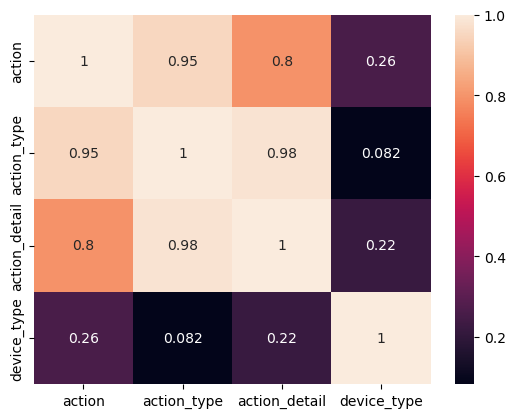

In [25]:
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot = True)

In [26]:
df2_sessions = df1_sessions.drop(['device_type', 'action_detail', 'action'], axis = 1)

In [27]:
df2_sessions['action_type_num'] = 1
df2_sessions = df2_sessions.drop(['action_type'], axis = 1)

In [28]:
df3_sessions = df2_sessions.groupby('user_id').agg({'secs_elapsed':'mean','action_type_num':'sum'}).reset_index()
df3_sessions = df3_sessions.rename(columns = {'user_id':'id'})

In [29]:
df3_sessions

,id,secs_elapsed,action_type_num
0,00023iyk9l,21060.057143,35
1,0010k6l0om,12455.936170,47
2,001wyh0pz8,3308.916667,84
3,0028jgx1x1,9900.333333,30
4,002qnbzfs5,5490.991489,705
...,...,...,...
133873,zzxox7jnrx,8524.549296,71
133874,zzy7t0y9cm,12293.500000,6
133875,zzysuoqg6x,865.500000,2
133876,zzywmcn0jv,38250.250000,40


In [30]:
df3_sessions[df3_sessions['id'] == '820tgsjxq7']

,id,secs_elapsed,action_type_num


# 2.0 Feature Engineering

In [31]:
df2 = df1.copy()

In [32]:
df2.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,2015-06-29,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
6,lsw9q7uk0j,2010-01-02,2010-01-02 01:25:58,2010-01-05,FEMALE,46,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


## 2.1 New Features

In [33]:
#days from first active up to first booking

df2['first_active'] = pd.to_datetime(df2['timestamp_first_active'].dt.strftime('%Y-%m-%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking'] - df2['first_active']).apply(lambda x: x.days)

#days from first active up to account created

df2['days_from_account_created_until_active'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

#days from account created to first booking

df2['days_from_account_created_until_first_booking'] = (df2['date_first_booking'] - df2['date_account_created']).apply(lambda x: x.days)

#days from first active until account created

df2['days_from_first_active_until_account_created'] = (df2['date_account_created'] - df2['first_active']).apply(lambda x: x.days)

#===============================First Active=========================================================

#Year of first active

df2['year_first_active'] = df2['first_active'].dt.year

#Month of first active

df2['month_first_active'] = df2['first_active'].dt.month

#Day of first active

df2['day_first_active'] = df2['first_active'].dt.day

#Day of week of first active

df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#Week of year first active

df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear

#===============================First booking=========================================================


#Year of first booking

df2['year_first_booking'] = df2['date_first_booking'].dt.year

#Month of first booking

df2['month_first_booking'] = df2['date_first_booking'].dt.month


#Day of first booking

df2['day_first_booking'] = df2['date_first_booking'].dt.day


#Day of week of first booking

df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#Week of year first booking

df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear

#===============================date account created=========================================================


#Year of account created

df2['year_account_created'] = df2['date_account_created'].dt.year

#Month of account created

df2['month_account_created'] = df2['date_account_created'].dt.month


#Day of account created

df2['day_account_created'] = df2['date_account_created'].dt.day


#Day of week of account created

df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#Week of year account created

df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear

C:\Users\gabriel.ferreira\AppData\Local\Temp\ipykernel_2956\1516516883.py:38: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_active'] = df2['first_active'].dt.weekofyear
C:\Users\gabriel.ferreira\AppData\Local\Temp\ipykernel_2956\1516516883.py:63: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_first_booking'] = df2['date_first_booking'].dt.weekofyear
C:\Users\gabriel.ferreira\AppData\Local\Temp\ipykernel_2956\1516516883.py:88: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year_account_created'] = df2['date_account_created'].dt.weekofyear


In [34]:
df2.dtypes

id                                                       object
date_account_created                             datetime64[ns]
timestamp_first_active                           datetime64[ns]
date_first_booking                               datetime64[ns]
gender                                                   object
age                                                       int64
signup_method                                            object
signup_flow                                               int64
language                                                 object
affiliate_channel                                        object
affiliate_provider                                       object
first_affiliate_tracked                                  object
signup_app                                               object
first_device_type                                        object
first_browser                                            object
country_destination                     

In [35]:
df2.shape

(122636, 36)

# 3.0 Data Filtering

In [36]:
df3 = df2.copy()

## 3.1 Filtering rows

In [37]:
#Filtering rows
#Age - greater more than 15 and lower than 120

df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

## 3.2 Filtering columns

In [38]:
cols = ['date_account_created','timestamp_first_active','date_first_booking','first_active'] #original datetime

# 4.0 Data Balanced

In [39]:
df4 = df3.drop(cols, axis = 1)
df41 = df4.drop('id', axis = 1)

In [40]:
# columns numerical

col_num = df4.select_dtypes(include = ['int64','float64']).columns.tolist()

# columns categorical

col_cat = df4.select_dtypes(exclude = ['int64','float64','datetime64[ns]']).drop(['id','country_destination'], axis = 1).columns.tolist()

# Encoder

ohe = pp.OneHotEncoder()

df4_dummy = pd.DataFrame(ohe.fit_transform(df4[col_cat]).toarray(), index = df4.index)

#Join

df42 = pd.concat([df4[col_num], df4_dummy], axis = 1)

df42.columns = df42.columns.astype(str)

In [41]:
df4_dummy

,0,1,2,3,4,5,6,7,8,9,...,108,109,110,111,112,113,114,115,116,117
1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213441,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213443,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
213446,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 4.1 Random Undersampling

In [42]:
#definir um sample (amostra)

under_sampling = us.RandomUnderSampler( sampling_strategy = 'not minority', random_state = 32 )

# aplicar o sample

x_under, y_under = under_sampling.fit_resample( df42, df4['country_destination'] )

In [43]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [44]:
y_under.value_counts()

AU       157
CA       157
DE       157
ES       157
FR       157
GB       157
IT       157
NDF      157
NL       157
PT       157
US       157
other    157
Name: country_destination, dtype: int64

## 4.2 Random Undersampling

In [45]:
#definir um sample (amostra)

over_sampling = oversample.RandomOverSampler( sampling_strategy = 'all', random_state = 32 )

# aplicar o sample

x_over, y_over = over_sampling.fit_resample( df42, df4['country_destination'] )

In [46]:
df4['country_destination'].value_counts()

NDF      54852
US       48057
other     7511
FR        3669
IT        2014
GB        1758
ES        1685
CA        1064
DE         841
NL         595
AU         433
PT         157
Name: country_destination, dtype: int64

In [47]:
y_over.value_counts()

NDF      54852
US       54852
other    54852
CA       54852
FR       54852
IT       54852
ES       54852
GB       54852
NL       54852
DE       54852
AU       54852
PT       54852
Name: country_destination, dtype: int64

## 4.3 SMOTE + TOMEKLINK

In [48]:
ratio_balanced = {'NDF': 54852,
 'US': 48057,
 'other': 7511*6,
 'FR': 3669*11,
 'IT': 2014*20,
 'GB': 1758*23,
 'ES': 1685*23,
 'CA': 1064*37,
 'DE': 841*47,
 'NL': 595*67,
 'AU': 433*92,
 'PT': 157*254}

ratio_balanced

{'NDF': 54852,
 'US': 48057,
 'other': 45066,
 'FR': 40359,
 'IT': 40280,
 'GB': 40434,
 'ES': 38755,
 'CA': 39368,
 'DE': 39527,
 'NL': 39865,
 'AU': 39836,
 'PT': 39878}

In [49]:
#definir um sample (amostra)

#smt = c.SMOTETomek(sampling_strategy = ratio_balanced, random_state = 32, n_jobs = -1)

# aplicar o sample

#x_smt, y_smt = smt.fit_resample(df42, df4['country_destination'])


In [50]:
#Numerical data

#df43 = x_smt[col_num]

#categorical data

#df44 = x_smt.drop(col_num, axis = 1)
#df45 = pd.DataFrame(ohe.inverse_transform(df44), columns = col_cat, index = df44.index)

#Join numerical data

#df46 = pd.concat([df43, df45], axis = 1)
#df46['country_destination'] = y_smt

In [51]:
#df46.to_csv('C:/Users/gabriel.ferreira/repos/PA/P001 - AirBNB/df46.csv')

# 5.0 Data Preparation

In [52]:
df46 = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001 - AirBNB/df46.csv')

## 5.1 Univariate Analysis - Feature Behaviour (Unbalanced Data)

In [53]:
df51 = df4.copy()

**H01** Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no AirBnb desde a sua primeira ativação

<AxesSubplot: xlabel='days_from_first_active_until_booking', ylabel='Count'>

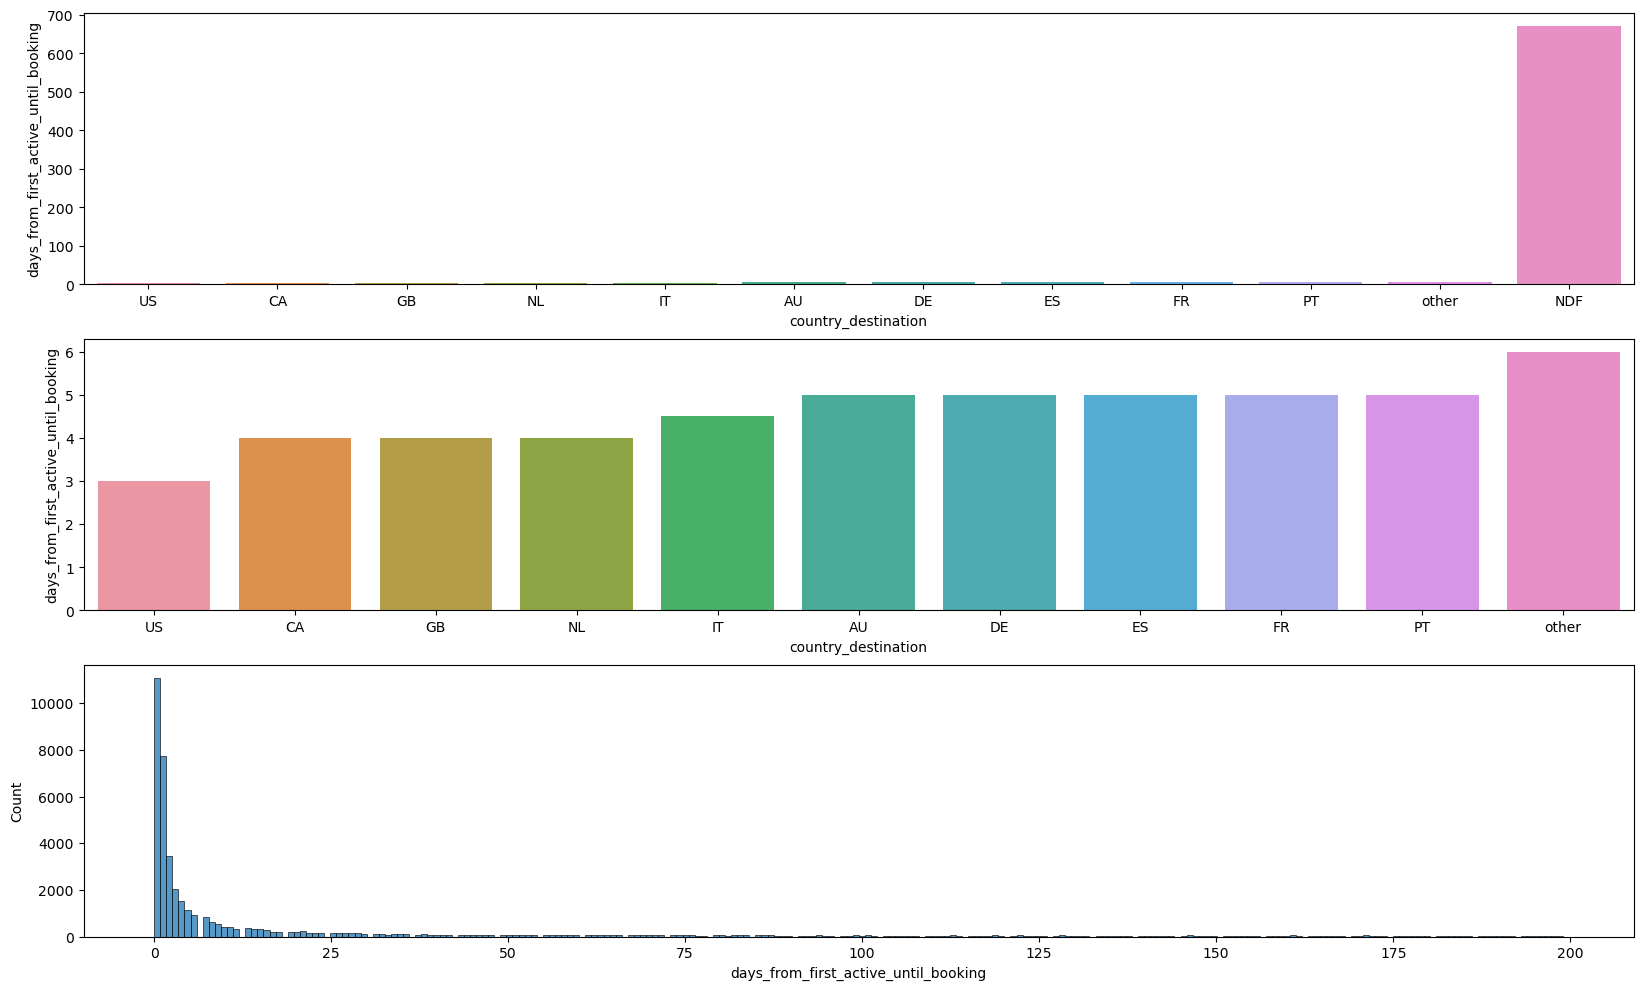

In [54]:
plt.figure(figsize = (20,12))
plt.subplot(3,1,1)

aux1 = df51.loc[:,['days_from_first_active_until_booking','country_destination']].\
        groupby('country_destination').median().\
        sort_values('days_from_first_active_until_booking').reset_index()

sns.barplot(x = 'country_destination', y = 'days_from_first_active_until_booking', data = aux1)

plt.subplot(3,1,2)

aux2 = df51[df51['country_destination'] != 'NDF']

aux2 = aux2[['days_from_first_active_until_booking','country_destination']].\
            groupby('country_destination').median().\
            sort_values('days_from_first_active_until_booking').reset_index()

sns.barplot(x = 'country_destination', y = 'days_from_first_active_until_booking', data = aux2)

plt.subplot(3,1,3)

aux3 = df51[(df51['days_from_first_active_until_booking'] < 200) & (df51['country_destination'] == 'US')]['days_from_first_active_until_booking']

sns.histplot(aux3)


**H02** Em todos os destinos, os usuários levam 03 dias, em média, para fazer o cadastro no site

<AxesSubplot: xlabel='country_destination', ylabel='days_from_account_created_until_active'>

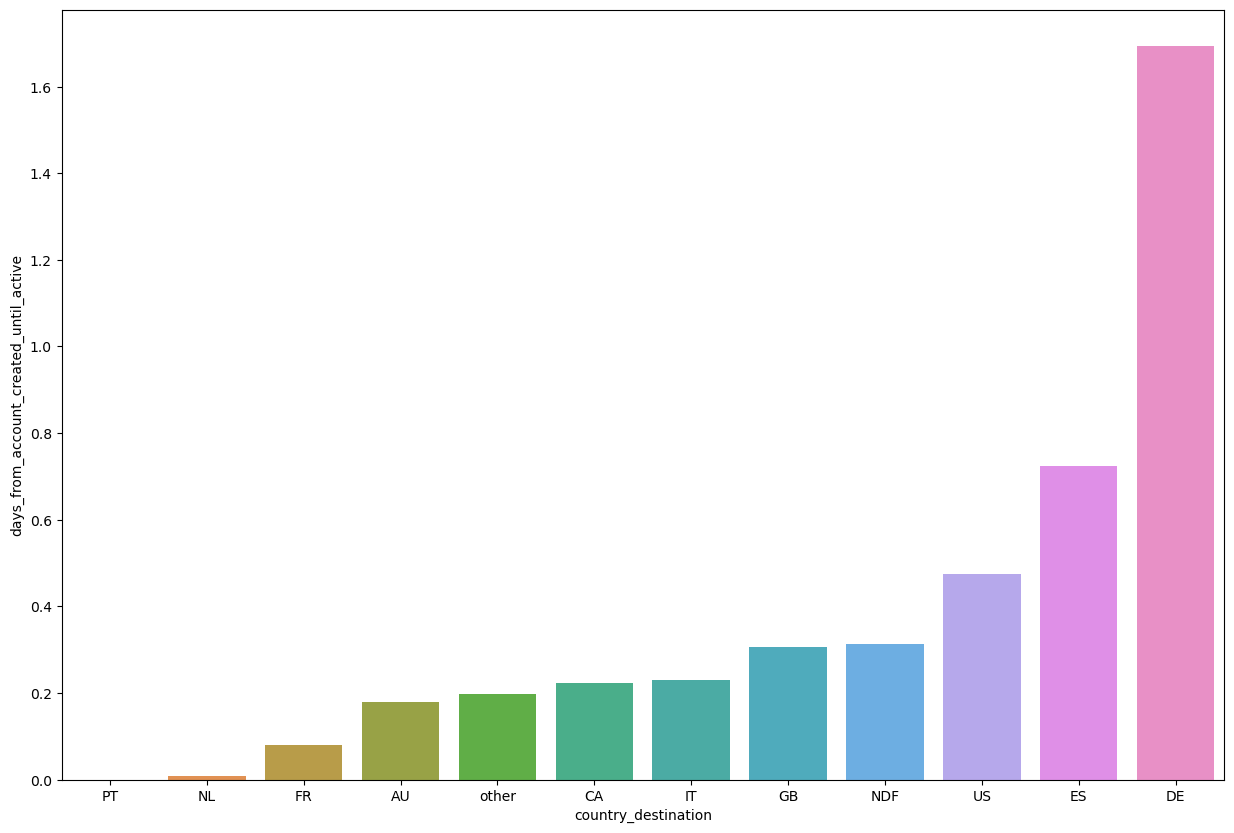

In [55]:
plt.figure(figsize = (15,10))

aux1 = df51[['days_from_account_created_until_active','country_destination']].\
        groupby('country_destination').mean().sort_values('days_from_account_created_until_active').reset_index()

sns.barplot(x = 'country_destination',y = 'days_from_account_created_until_active', data = aux1)

**H03** O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA

<AxesSubplot: xlabel='year_first_booking', ylabel='delta'>

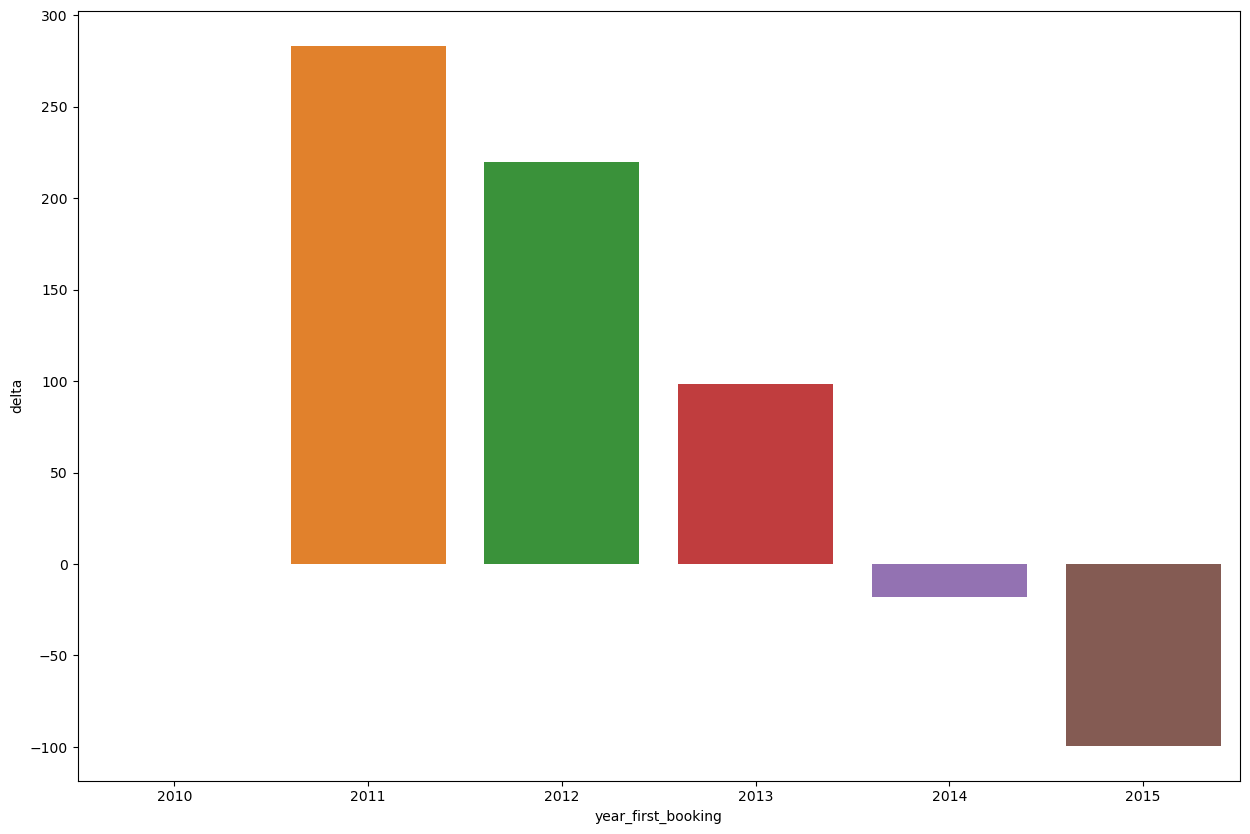

In [56]:
plt.figure(figsize = (15,10))

aux1 = df51[(df51['month_first_booking'].isin([6,7,8,9])) & (df51['country_destination'] == 'US')]

aux1 = aux1[['month_first_booking','year_first_booking']].\
            groupby('year_first_booking').count().sort_values('year_first_booking').reset_index()

aux1['delta'] = aux1['month_first_booking'].pct_change().fillna(0)*100

aux1

sns.barplot(x = 'year_first_booking', y = 'delta', data = aux1)

**H04** Usários do sexo feminino fazem 10% mais reservas para países fora dos USA

In [57]:
aux1 = df51.loc[df51['gender'] == 'FEMALE',['gender','country_destination']]

aux11 = aux1[aux1['country_destination'] == 'US']

aux11 = aux11[['gender','country_destination']].groupby('gender').count().reset_index()

aux12 = aux1[aux1['country_destination'] != 'US']

aux12 = aux12[['gender','country_destination']].groupby('gender').count().reset_index()


aux13 = (35295 / 21067) * 100

aux13

167.53690606161297

**H05** O canal de marketing Google representa 40% das reservas para países fora dos USA

In [58]:
aux1 = df51.loc[df51['affiliate_provider'] == 'google',:]
aux1 = aux1[['affiliate_provider','country_destination']].groupby('country_destination').count().\
            sort_values('affiliate_provider', ascending = False).reset_index()

aux1

aux1.value_counts(normalize = True)



country_destination  affiliate_provider
AU                   99                    0.083333
CA                   249                   0.083333
DE                   215                   0.083333
ES                   401                   0.083333
FR                   967                   0.083333
GB                   442                   0.083333
IT                   525                   0.083333
NDF                  13543                 0.083333
NL                   165                   0.083333
PT                   45                    0.083333
US                   10618                 0.083333
other                1793                  0.083333
dtype: float64

**H06** O destino USA representa mais de 20% em todos os canais

In [59]:
aux1 = df51[['country_destination','affiliate_channel']].groupby('country_destination').\
            count().reset_index()

aux1['affiliate_channel_percent'] = (aux1['affiliate_channel'] / aux1['affiliate_channel'].sum())*100

aux1

,country_destination,affiliate_channel,affiliate_channel_percent
0,AU,433,0.353077
1,CA,1064,0.867608
2,DE,841,0.685769
3,ES,1685,1.373985
4,FR,3669,2.991781
5,GB,1758,1.433511
6,IT,2014,1.642258
7,NDF,54852,44.727486
8,NL,595,0.485176
9,PT,157,0.128021


**H07** A idade média das pessoas é de 35 anos em todos os destinos

In [60]:
aux1 = df51[['age','country_destination']].groupby('country_destination').\
            mean().sort_values('age', ascending = False).reset_index()

aux1

,country_destination,age
0,GB,39.036405
1,AU,38.293303
2,IT,38.052135
3,FR,38.021259
4,CA,37.897556
5,NDF,37.793863
6,DE,37.343639
7,other,37.336573
8,US,36.889714
9,NL,36.736134


**H08** A porcentagem de usuários que usam o site na lingua inglês americano para reservar acomodações em qualquer destino é maior que 90%

In [61]:
aux1 = df51['language'].value_counts(normalize = True)

aux1

en    0.963869
zh    0.007347
fr    0.006580
es    0.005096
de    0.003319
ko    0.003221
it    0.002830
ru    0.002193
pt    0.001378
ja    0.001060
sv    0.000644
nl    0.000424
tr    0.000367
pl    0.000342
da    0.000269
el    0.000179
no    0.000163
cs    0.000147
id    0.000139
th    0.000139
hu    0.000122
fi    0.000090
ca    0.000033
is    0.000033
hr    0.000016
Name: language, dtype: float64

**H09** O número de reservas do AirBNB é crescente ao longo dos anos

<AxesSubplot: xlabel='year_first_booking', ylabel='country_destination'>

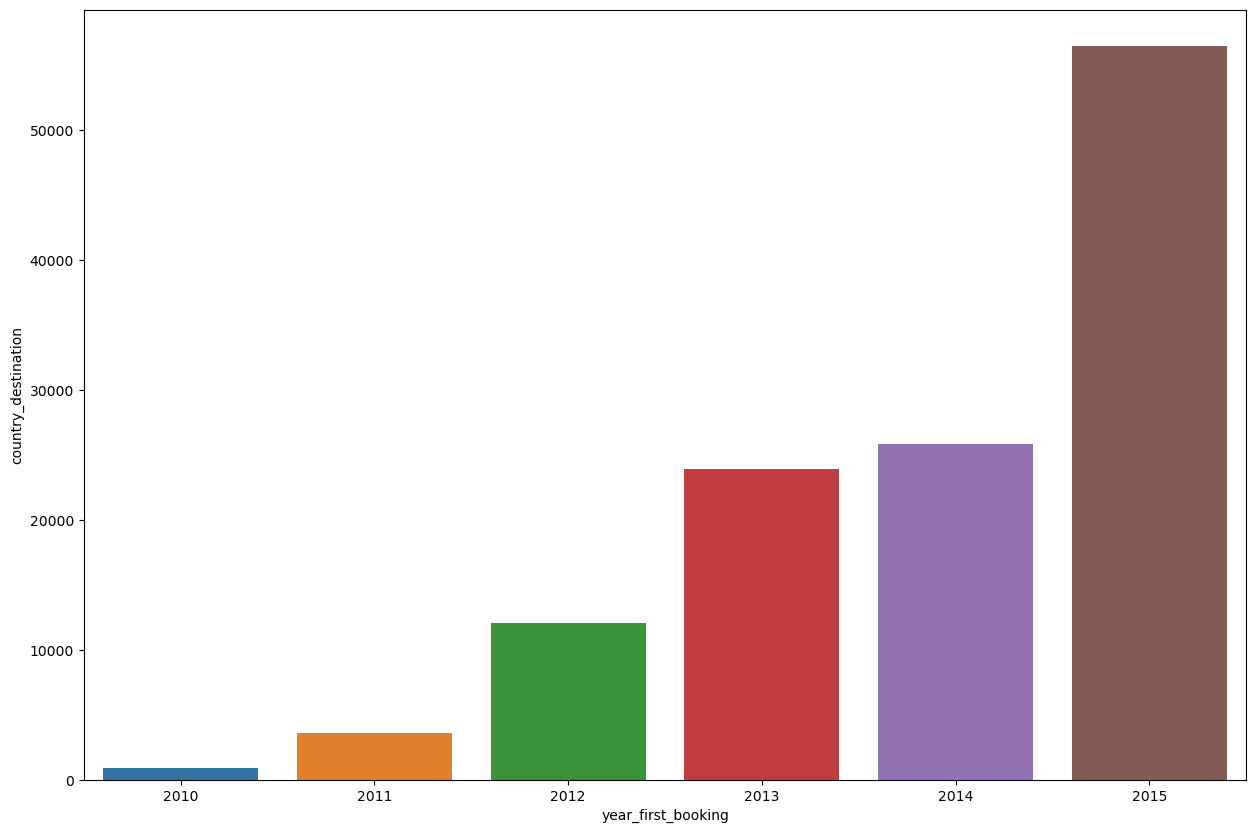

In [62]:
plt.figure(figsize = (15,10))

aux1 = df51[['year_first_booking','country_destination']].groupby('year_first_booking').count().reset_index()

sns.barplot(x = 'year_first_booking', y = 'country_destination', data = aux1)

## 5.2 Bivariate Analysis - Feature Behaviour (Balanced Data)

In [63]:
df52 = df46.copy()

### 5.2.1 Univariate Analysis

In [64]:
#profile = ProfileReport(df52, title = 'AirBNB report')
#profile.to_file(output_file = 'airbnb_booking_statistics_after_cleaning.html')

### 5.2.2 Bivariate Analysis

### 5.2.3 Multivariate Analysis

C:\Users\gabriel.ferreira\AppData\Local\Temp\ipykernel_2956\845249778.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df52.corr()


<AxesSubplot: >

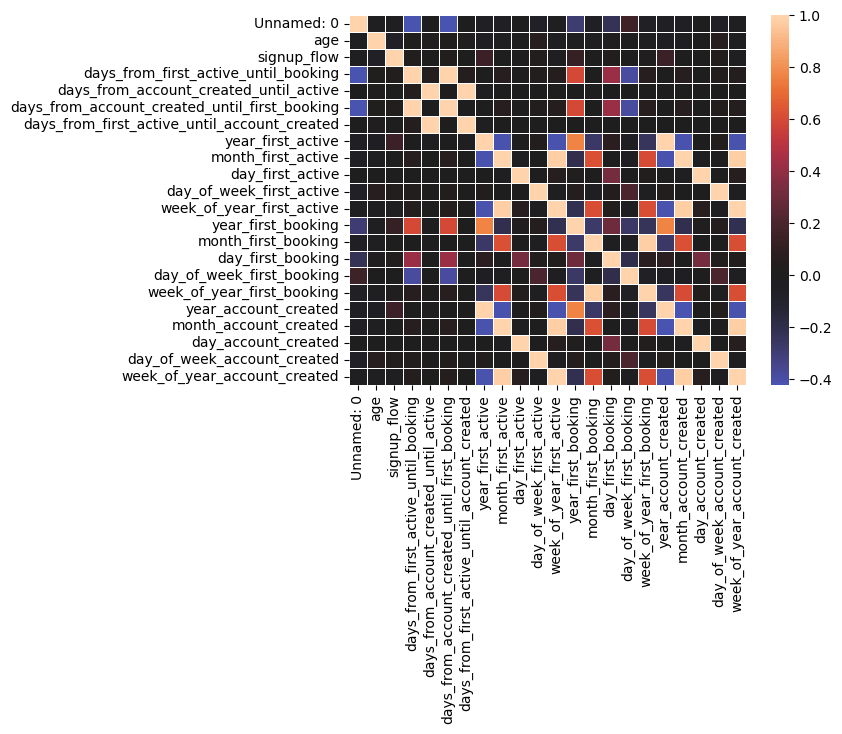

In [65]:
corr = df52.corr()
sns.heatmap(corr,center=0, linewidths=.5)

In [66]:
cols = ['Unnamed: 0','days_from_first_active_until_booking','year_first_active','month_first_active','day_first_active',
       'day_of_week_first_active','week_of_year_first_active','month_first_booking','month_account_created',
       'year_first_booking','week_of_year_first_booking','affiliate_provider','first_browser',
       'first_device_type','language','days_from_account_created_until_active'] # High correlation

# 6.0 Data Preparation

In [67]:
df6 = df46.drop(cols, axis = 1)
df6.shape

(504995, 16)

## 6.1 Rescaling

In [68]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [69]:
# Age - Standartization

df6['age'] = ss.fit_transform(df6[['age']].values)

#signup_flow - Robust Scaler

df6['signup_flow'] = rs.fit_transform(df6[['signup_flow']].values)

#days_from_account_created_until_first_booking - Robust Scaler

df6['days_from_account_created_until_first_booking'] = rs.fit_transform(df6[['days_from_account_created_until_first_booking']].values)

#days_from_first_active_until_account_created - Min Max Scaler

df6['days_from_first_active_until_account_created'] = mms.fit_transform(df6[['days_from_first_active_until_account_created']].values)

#year_account_created - Min Max Scaler

df6['year_account_created'] = mms.fit_transform(df6[['year_account_created']].values)

## 6.2 Encoding

In [70]:
ohe = pp.OneHotEncoder()
te =  TargetEncoder()

In [71]:
df6['country_destination'].drop_duplicates().tolist()

['NDF', 'US', 'other', 'CA', 'FR', 'IT', 'ES', 'GB', 'NL', 'DE', 'AU', 'PT']

In [72]:
#gender - OHE

df6 = pd.get_dummies(df6, prefix = ['gender'], columns = ['gender'])

#signup_method - OHE

df6 = pd.get_dummies(df6, prefix = ['signup_method'], columns = ['signup_method'])


#signup_app - OHE

df6 = pd.get_dummies(df6, prefix = ['signup_app'], columns = ['signup_app'])


#affiliate_channel - Target encoding

c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}

df6['affiliate_channel'] = te.fit_transform(df6[['affiliate_channel']].values, df6['country_destination'].map(c))

#first_affiliate_tracked - Target encoding

df6['first_affiliate_tracked'] = te.fit_transform(df6[['first_affiliate_tracked']].values, df6['country_destination'].map(c))


## 6.3 Transformation

In [73]:
#day_first_booking

df6['day_first_booking_sin'] = df6['day_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/31)))
df6['day_first_booking_cos'] = df6['day_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/31)))


#day_of_week_first_booking

df6['day_of_week_first_booking_sin'] = df6['day_of_week_first_booking'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_first_booking_cos'] = df6['day_of_week_first_booking'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#day_account_created

df6['day_account_created_sin'] = df6['day_account_created'].apply(lambda x: np.sin(x * (2*np.pi/31)))
df6['day_account_created_cos'] = df6['day_account_created'].apply(lambda x: np.cos(x * (2*np.pi/31)))

#day_of_week_account_created

df6['day_of_week_account_created_sin'] = df6['day_of_week_account_created'].apply(lambda x: np.sin(x * (2*np.pi/7)))
df6['day_of_week_account_created_cos'] = df6['day_of_week_account_created'].apply(lambda x: np.cos(x * (2*np.pi/7)))

#week_of_year_account_created

df6['week_of_year_account_created_sin'] = df6['week_of_year_account_created'].apply(lambda x: np.sin(x * (2*np.pi/52)))
df6['week_of_year_account_created_cos'] = df6['week_of_year_account_created'].apply(lambda x: np.cos(x * (2*np.pi/52)))


# 7.0 Feature Selection

In [74]:
df7 = df6.copy()

In [75]:
#country_destination - Label encoding

le = pp.LabelEncoder()

df7['country_destination'] = le.fit_transform(df6[['country_destination']])

C:\Users\gabriel.ferreira\Anaconda3\envs\PA001-AirBNB\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 7.1 BorutaPy

In [76]:
x = df7.drop(df7[['country_destination','country_destination']], axis = 1).values
y = df7['country_destination'].copy().values

### 7.1.1 BorutaPy with Random forest regressor

In [77]:
#define random forest regressor, with utilising all cores and sampling in proportion to y labels
#forest = RandomForestRegressor(max_depth = 5, random_state = 42)

#define Boruta feature selection method
#feat_selector = BorutaPy(forest, n_estimators='auto',max_iter = 70, verbose=2, random_state=42)

#find all relevant features
#feat_selector.fit(x, y)

In [78]:
# check selected features
#feat_selector.support_

In [79]:
#x = pd.DataFrame(x)
#df7_aux = df7.drop(['country_destination'], axis = 1)
#x.columns = df7_aux.columns
#x.columns[feat_selector.support_]

In [80]:
cols = ['age', 'signup_flow', 'days_from_account_created_until_first_booking',
       'day_first_booking', 'day_of_week_first_booking',
       'year_account_created', 'day_account_created',
       'day_of_week_account_created', 'week_of_year_account_created',
       'affiliate_channel', 'first_affiliate_tracked', 'signup_app_Web',
       'day_first_booking_sin', 'day_first_booking_cos',
       'day_of_week_first_booking_sin', 'day_of_week_first_booking_cos',
       'day_account_created_sin', 'day_account_created_cos',
       'day_of_week_account_created_cos', 'week_of_year_account_created_sin',
       'week_of_year_account_created_cos']

In [81]:
y = le.inverse_transform(y)

# 8.0 Feature Selection

In [82]:
df8 = df7[cols].copy()
y = pd.DataFrame(y)
df8 = pd.concat([df8,y], axis = 1)
df8.rename(columns = {0: 'country_destination'}, inplace = True)
df8

,age,signup_flow,days_from_account_created_until_first_booking,day_first_booking,day_of_week_first_booking,year_account_created,day_account_created,day_of_week_account_created,week_of_year_account_created,affiliate_channel,...,day_first_booking_sin,day_first_booking_cos,day_of_week_first_booking_sin,day_of_week_first_booking_cos,day_account_created_sin,day_account_created_cos,day_of_week_account_created_cos,week_of_year_account_created_sin,week_of_year_account_created_cos,country_destination
0,0.089302,0.0,13.070175,29,0,0.25,25,2,21,5.124376,...,-0.394356,0.918958,0.000000,1.000000,-0.937752,0.347305,-0.222521,0.568065,-8.229839e-01,NDF
1,1.452481,3.0,-0.552632,2,0,0.00,28,1,39,5.255325,...,0.394356,0.918958,0.000000,1.000000,-0.571268,0.820763,0.623490,-1.000000,-1.836970e-16,US
2,0.392231,0.0,2.385965,8,5,0.25,5,0,49,5.255325,...,0.998717,-0.050649,-0.974928,-0.222521,0.848644,0.528964,1.000000,-0.354605,9.350162e-01,other
3,0.316498,0.0,-1.877193,18,3,0.00,14,1,37,5.255325,...,-0.485302,-0.874347,0.433884,-0.900969,0.299363,-0.954139,0.623490,-0.970942,-2.393157e-01,US
4,0.695159,0.0,-0.026316,5,1,0.00,2,5,53,4.462750,...,0.848644,0.528964,0.781831,0.623490,0.394356,0.918958,-0.222521,0.120537,9.927089e-01,US
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
504990,-0.289359,0.0,-0.043860,22,4,0.75,20,2,12,5.255325,...,-0.968077,-0.250653,-0.433884,-0.900969,-0.790776,-0.612106,-0.222521,0.992709,1.205367e-01,other
504991,-0.213627,0.0,0.403509,29,3,0.50,7,0,27,5.255325,...,-0.394356,0.918958,0.433884,-0.900969,0.988468,0.151428,1.000000,-0.120537,-9.927089e-01,other
504992,-0.592288,0.0,0.140351,13,3,0.75,21,2,21,5.255325,...,0.485302,-0.874347,0.433884,-0.900969,-0.897805,-0.440394,-0.222521,0.568065,-8.229839e-01,other
504993,-0.365091,0.0,-0.026316,16,3,1.00,13,0,3,5.255325,...,-0.101168,-0.994869,0.433884,-0.900969,0.485302,-0.874347,1.000000,0.354605,9.350162e-01,other


In [83]:
#cols_drop = ['date_account_created','timestamp_first_active', 'date_first_booking','first_active'] #original dates
#df6 = df5.drop(cols_drop, axis = 1)

In [84]:
x = df8.drop(['country_destination'], axis = 1)
y = df8['country_destination'].copy()

In [85]:
#split train and test data

x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size = 0.2, random_state = 42)

In [86]:
#split train and validation data

x_train, x_val, y_train, y_val = ms.train_test_split(x_train, y_train, test_size = 0.2, random_state = 42)


# 9.0 Machine Learning Model

In [87]:
print('Number of rows: {}'.format(x_train.shape[0]))
print('Number of features: {}'.format(x_train.shape[1]))
print('Number of classes: {}'.format(y_train.nunique()))

Number of rows: 323196
Number of features: 21
Number of classes: 12


## 9.1 Baseline Model

In [88]:
country_list = df1['country_destination'].drop_duplicates().sort_values().tolist()
k = y_test.shape[0]
weights = df1['country_destination'].value_counts(normalize = True).sort_index().tolist()

yhat_random = random.choices(population = country_list, weights = weights, k = k )

Accuracy 0.09781284963217457
Balanced Accuracy 0.08286295694025429
Kappa Score -0.0006371090736301266


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

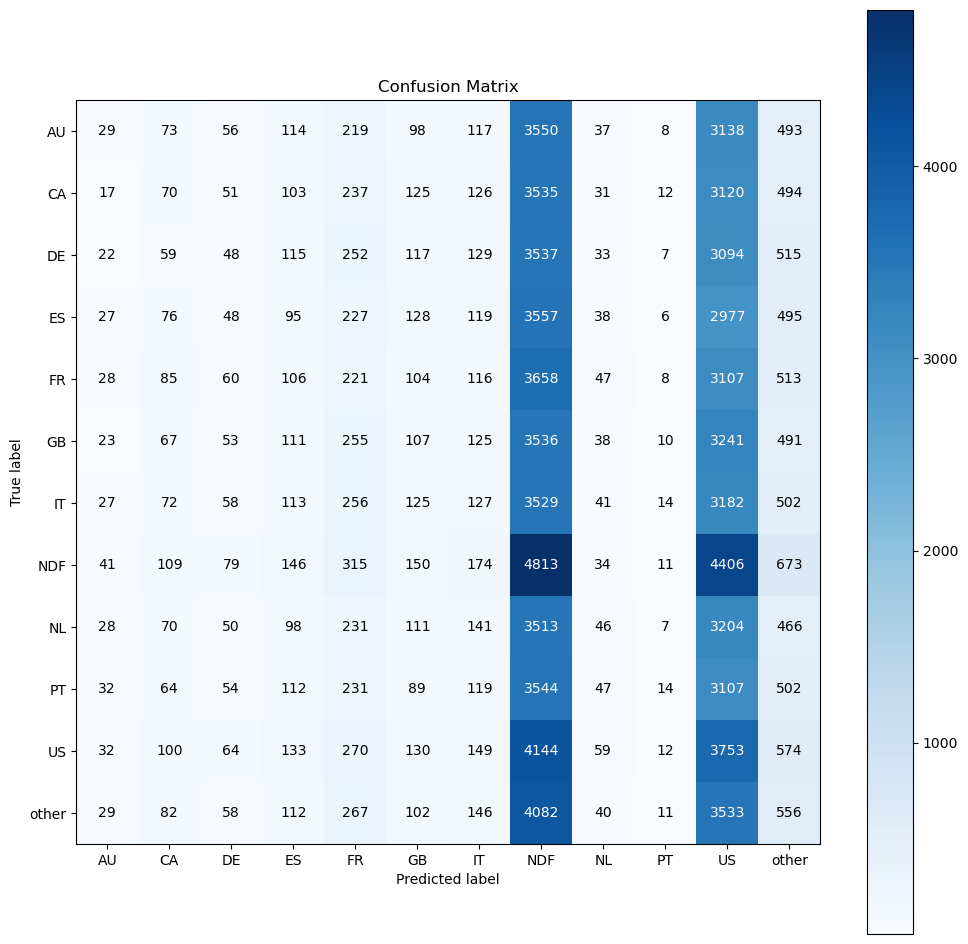

In [89]:
# Accuracy

acc_random = m.accuracy_score(y_test, yhat_random)
print('Accuracy {}'.format(acc_random))

# Balanced accuracy

balanced_acc_random = m.balanced_accuracy_score(y_test, yhat_random)

print('Balanced Accuracy {}'.format(balanced_acc_random))

# Kappa Score

kappa_random = m.cohen_kappa_score(y_test, yhat_random)

print('Kappa Score {}'.format(kappa_random))


# Confusion Matrix

mt.plot_confusion_matrix(y_test, yhat_random, normalize = False, figsize=(12,12))

## 9.2 KNN

In [90]:
x_train_knn = x_train
y_train_knn = y_train

In [91]:
model_knn = KNeighborsClassifier(n_neighbors = 5)

model_knn.fit(x_train_knn, y_train_knn)

yhat_knn = model_knn.predict(x_val)

Accuracy: 0.7488737623762376
Balanced Accuracy: 0.7525998725032279
Kappa Score: 0.7260447465369357


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

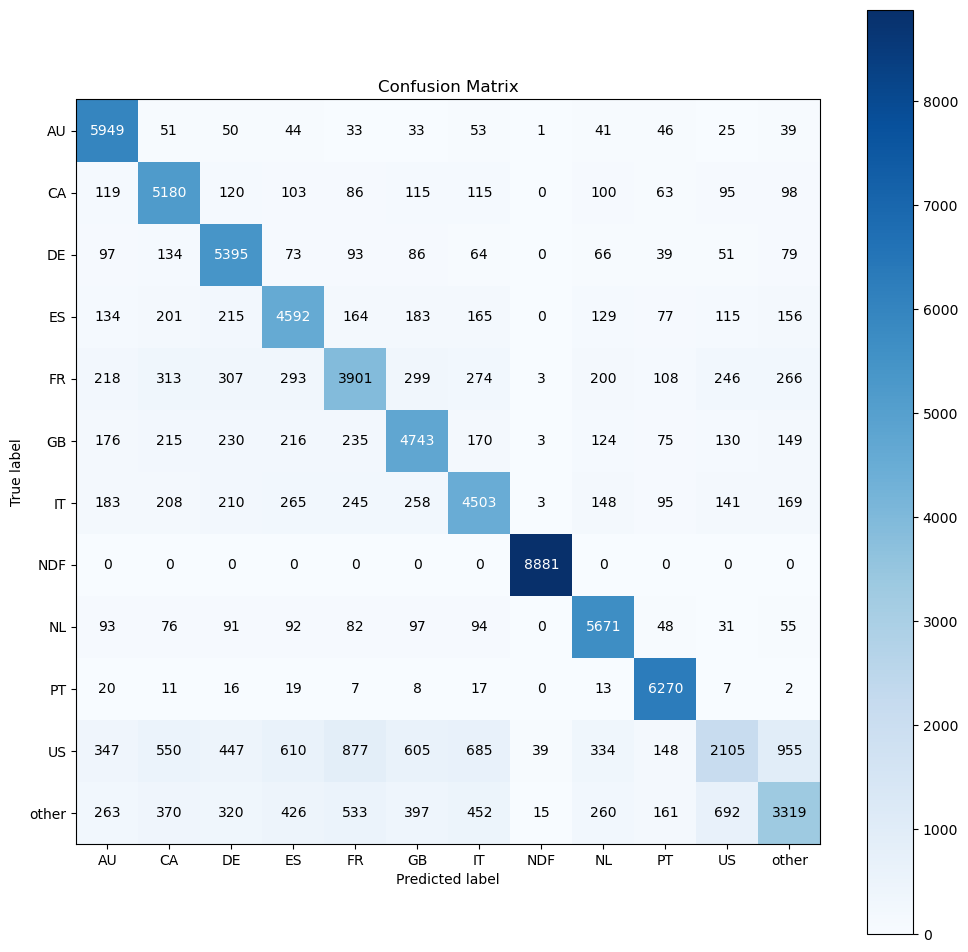

In [92]:
#Accuracy

acc_knn = m.accuracy_score(y_val, yhat_knn)

# Balanced Accuracy

balanced_acc_knn = m.balanced_accuracy_score(y_val, yhat_knn)

#Kappa score

kappa_knn = m.cohen_kappa_score(y_val, yhat_knn)

print('Accuracy: {}'.format(acc_knn))
print('Balanced Accuracy: {}'.format(balanced_acc_knn))
print('Kappa Score: {}'.format(kappa_knn))

#Matrix confusion

mt.plot_confusion_matrix(y_val, yhat_knn, normalize = False, figsize=(12,12))

## 9.6  Cross Validation - KNN

In [93]:
#generate k-fold

folds = 5
kfold = ms.StratifiedKFold(n_splits = folds, shuffle = True, random_state = 32)

balanced_fold_list = []
kappa_fold_list = []

i = 1

for train_ix, val_ix in kfold.split(x_train, y_train): #pegará as proporções das classes
    print('Fold number: {}/{}'.format(i, folds))
    
    
    #get fold
    x_train_fold = x_train.iloc[train_ix]
    y_train_fold = y_train.iloc[train_ix]
    
    x_val_fold = x_train.iloc[val_ix]
    y_val_fold = y_train.iloc[val_ix]

    #model definition
    
    model_knn_fold = KNeighborsClassifier(n_neighbors = 5)

    #training model
    
    model_knn_fold.fit(x_train_fold, y_train_fold)

    #prediction
    
    yhat_knn_fold = model_knn_fold.predict(x_val_fold)
    
    #Balanced Accuracy

    balanced_fold = m.balanced_accuracy_score(y_val_fold, yhat_knn_fold)
    balanced_fold_list.append(balanced_fold)

    #Kappa Score

    kappa_fold = m.cohen_kappa_score(y_val_fold, yhat_knn_fold)
    kappa_fold_list.append(kappa_fold)
    
    i = i + 1

Fold number: 1/5
Fold number: 2/5
Fold number: 3/5
Fold number: 4/5
Fold number: 5/5


# 10.0 ML Model Performance

In [94]:
#prediction

yhat_knn_final = model_knn_fold.predict(x_test)

Accuracy: 0.7262151110407034
Balanced Accuracy: 0.7287362295488697
Kappa Score: 0.701342479750084


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

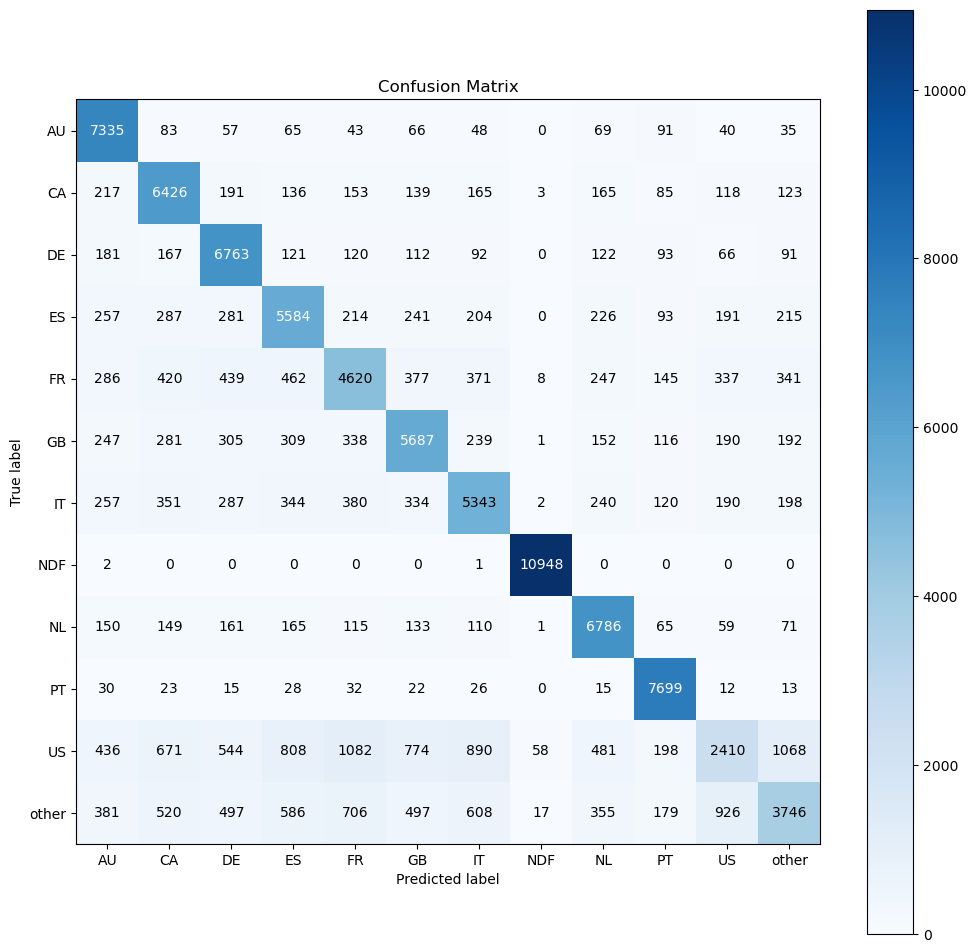

In [95]:
#Accuracy

acc_knn_cross_validation = m.accuracy_score(y_test, yhat_knn_final)

# Balanced Accuracy

balanced_knn_cross_validation = m.balanced_accuracy_score(y_test, yhat_knn_final)

#Kappa score

kappa_knn_cross_validation = m.cohen_kappa_score(y_test, yhat_knn_final)

print('Accuracy: {}'.format(acc_knn_cross_validation))
print('Balanced Accuracy: {}'.format(balanced_knn_cross_validation))
print('Kappa Score: {}'.format(kappa_knn_cross_validation))

#Matrix confusion

mt.plot_confusion_matrix(y_test, yhat_knn_final, normalize = False, figsize=(12,12))

In [96]:
data_knn = {'KNN': [acc_knn, balanced_acc_knn, kappa_knn],
           'KNN - Cross Validation': [acc_knn_cross_validation, balanced_knn_cross_validation, kappa_knn_cross_validation]}

df_comp_knn = pd.DataFrame(data_knn, index = ['Accuracy', 'Balanced Accuracy','Kappa Score'])

df_comp_knn

,KNN,KNN - Cross Validation
Accuracy,0.748874,0.726215
Balanced Accuracy,0.752600,0.728736
Kappa Score,0.726045,0.701342


# 11.0 HyperParameters

In [97]:
# Definindo os possíveis valores dos hiperparâmetros

#param_grid = {
#    'n_neighbors': [3, 5, 7],
#    'weights': ['uniform', 'distance'],
#    'metric': ['euclidean', 'manhattan']}

In [98]:
# Realizando a busca de hiperparâmetros usando validação cruzada

#knn = KNeighborsClassifier()

#grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
#grid_search.fit(x_train, y_train)

In [99]:
# Extraindo o melhor modelo e os melhores hiperparâmetros

#best_model = grid_search.best_estimator_
#best_params = grid_search.best_params_

In [100]:
# Imprimindo os melhores hiperparâmetros encontrados

#print("Melhores hiperparâmetros: {}".format(best_params))

In [101]:
model_knn_final = KNeighborsClassifier(metric = 'manhattan', n_neighbors = 3, weights = 'distance')

In [102]:
model_knn_final.fit(x_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=3, weights='distance')

In [103]:
yhat_knn_hiper = model_knn_final.predict(x_val)

Accuracy: 0.8410767326732673
Balanced Accuracy: 0.845595542105317
Kappa Score: 0.8265427634306053


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

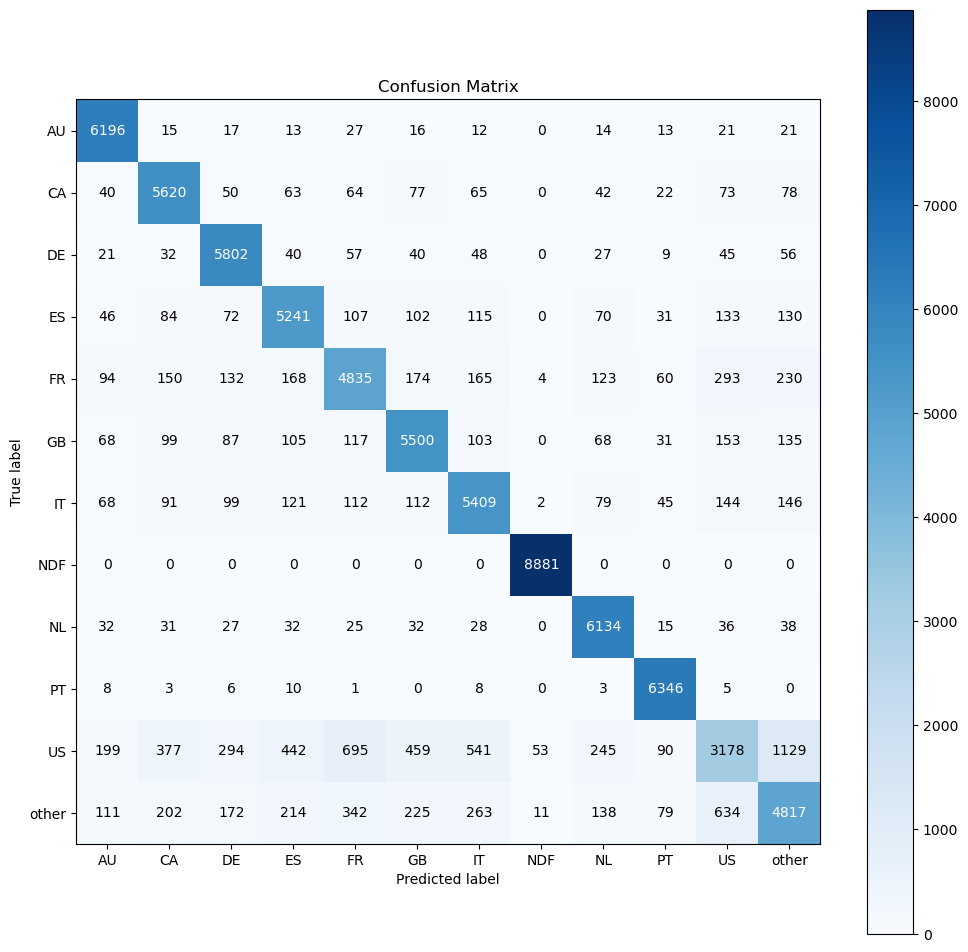

In [104]:
acc_knn_hiper = m.accuracy_score(y_val, yhat_knn_hiper)
balanced_knn_hiper = m.balanced_accuracy_score(y_val, yhat_knn_hiper)
kappa_knn_hiper = m.cohen_kappa_score(y_val, yhat_knn_hiper)

print('Accuracy: {}'.format(acc_knn_hiper))
print('Balanced Accuracy: {}'.format(balanced_knn_hiper))
print('Kappa Score: {}'.format(kappa_knn_hiper))

mt.plot_confusion_matrix(y_val, yhat_knn_hiper, normalize = False, figsize=(12,12))

In [105]:
data_knn_hiper = {'KNN': [acc_knn, balanced_acc_knn, kappa_knn],
                   'KNN - Cross Validation': [acc_knn_cross_validation, balanced_knn_cross_validation, kappa_knn_cross_validation],
                   'KNN - HiperParameters':[acc_knn_hiper, balanced_knn_hiper, kappa_knn_hiper]}

df_comp_knn_hiper = pd.DataFrame(data_knn_hiper, index = ['Accuracy', 'Balanced Accuracy','Kappa Score'])

df_comp_knn_hiper

,KNN,KNN - Cross Validation,KNN - HiperParameters
Accuracy,0.748874,0.726215,0.841077
Balanced Accuracy,0.752600,0.728736,0.845596
Kappa Score,0.726045,0.701342,0.826543


# 12.0 With Data Test

In [106]:
df_test = pd.read_csv('C:/Users/gabriel.ferreira/repos/PA/P001 - AirBNB/test_users.csv')

In [107]:
yhat_test = model_knn_final.predict(x_test)

Accuracy: 0.8396320755651046
Balanced Accuracy: 0.8434333005100183
Kappa Score: 0.8249788043838486


<AxesSubplot: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

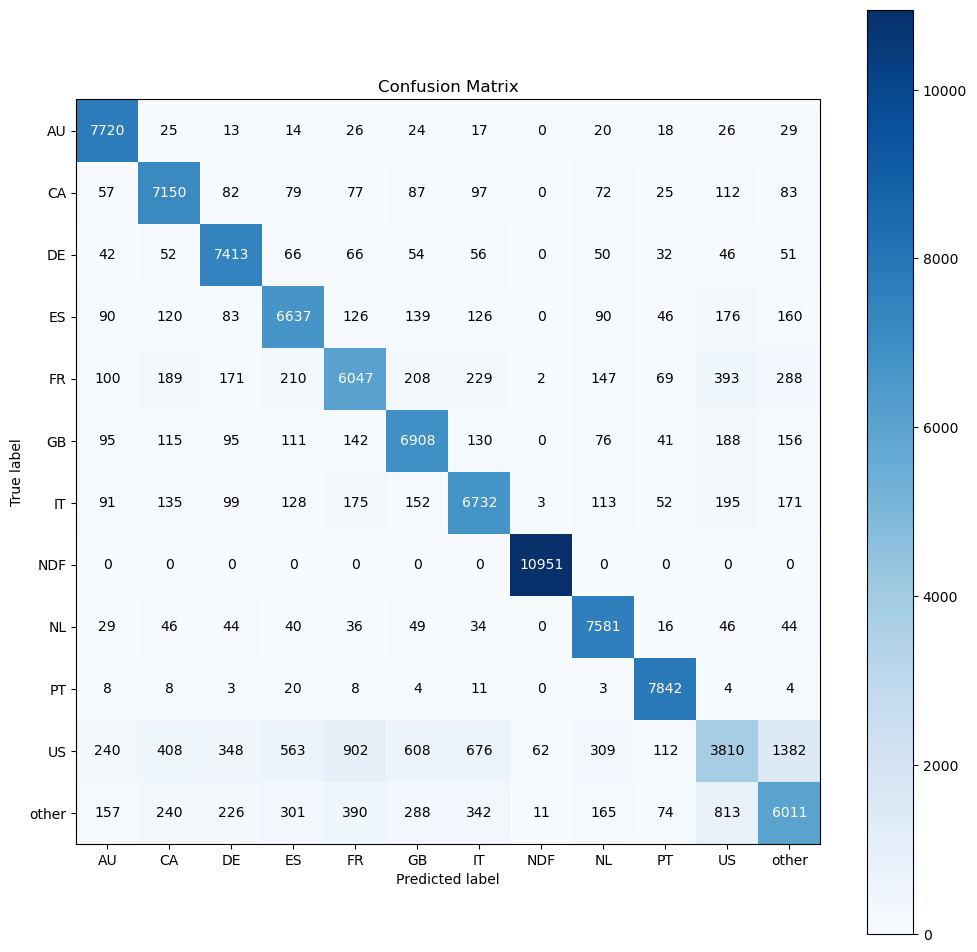

In [108]:
acc_knn_test = m.accuracy_score(y_test, yhat_test)
balanced_knn_test = m.balanced_accuracy_score(y_test, yhat_test)
kappa_knn_test = m.cohen_kappa_score(y_test, yhat_test)

print('Accuracy: {}'.format(acc_knn_test))
print('Balanced Accuracy: {}'.format(balanced_knn_test))
print('Kappa Score: {}'.format(kappa_knn_test))

mt.plot_confusion_matrix(y_test, yhat_test, normalize = False, figsize=(12,12))